In [1]:
pip install pandas matplotlib seaborn statsmodels openpyxl

In [11]:
df = pd.read_excel('/content/Predicting Energy Consumption.xlsm')

# Exploratory Data Analysis

Missing values per column:
 End time UTC                     0
Electricity consumption (MWh)    0
dtype: int64


/tmp/ipython-input-679600198.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Electricity consumption (MWh)'] = df['Electricity consumption (MWh)'].fillna(method='ffill')


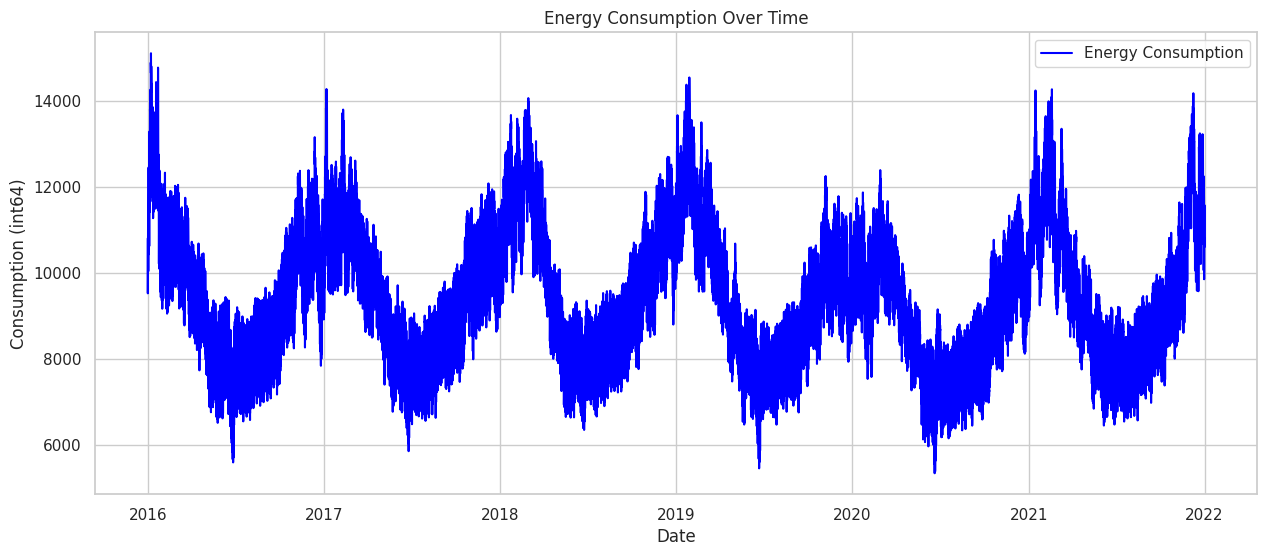

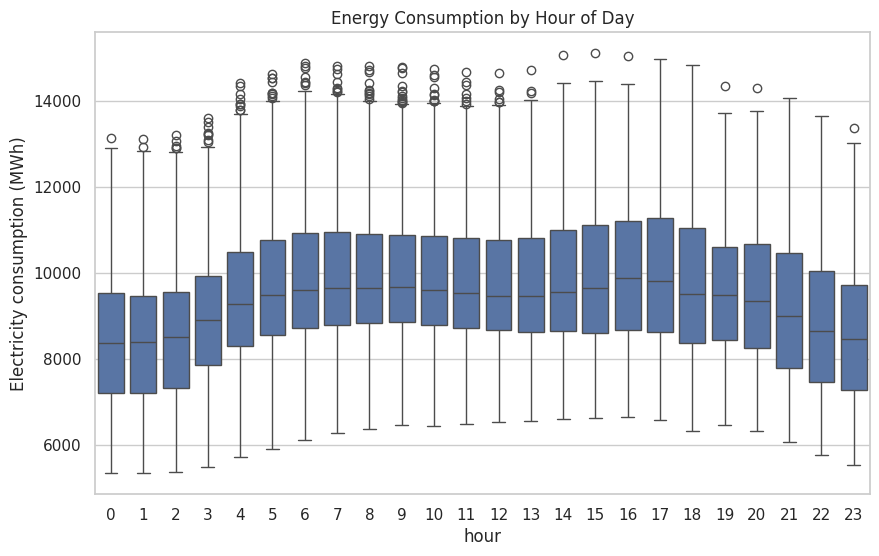

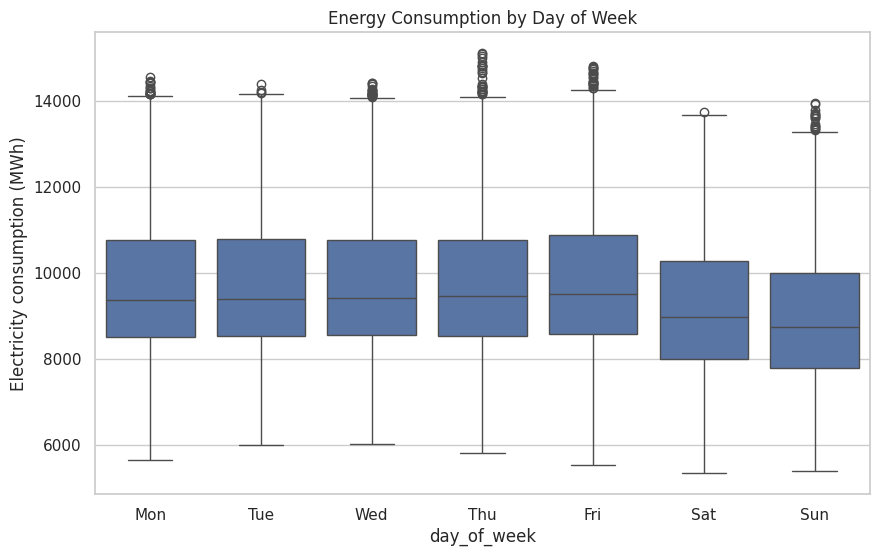

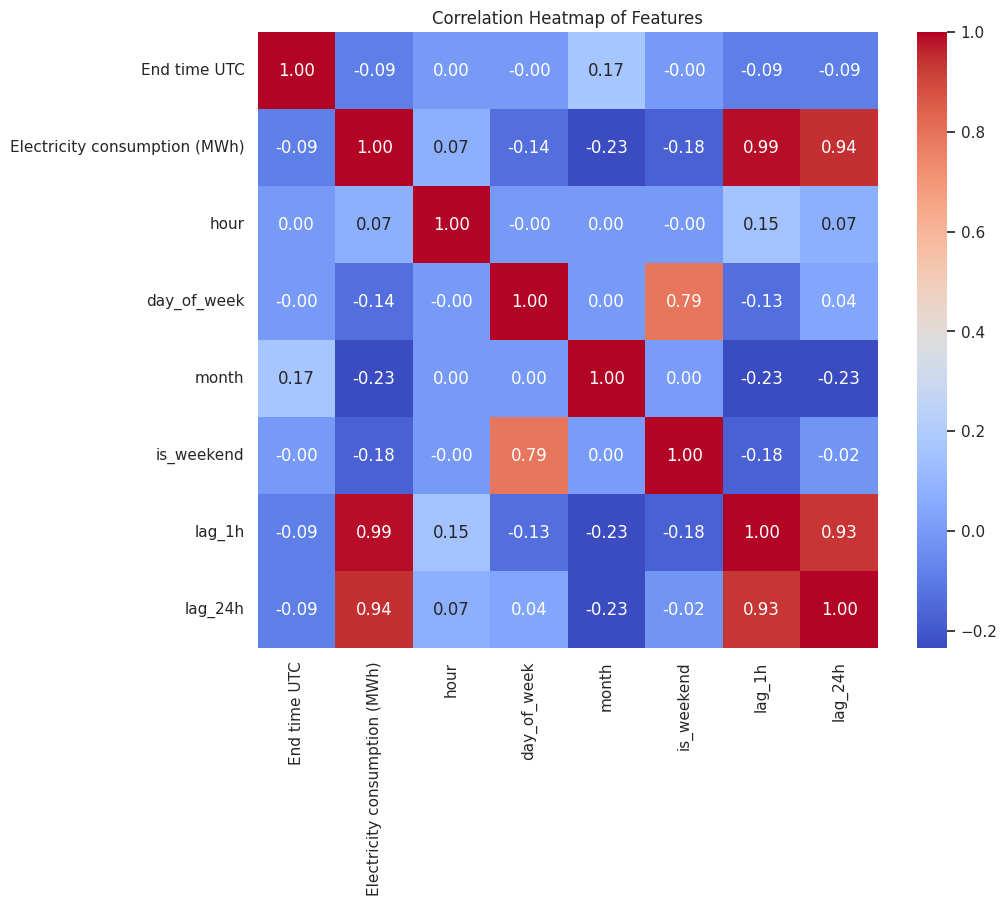

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel('/content/Predicting Energy Consumption.xlsm')
df['Start time UTC'] = pd.to_datetime(df['Start time UTC'])
df['End time UTC'] = pd.to_datetime(df['End time UTC'])

df.set_index('Start time UTC', inplace=True)
df.sort_index(inplace=True)

print("Missing values per column:\n", df.isnull().sum())
df['Electricity consumption (MWh)'] = df['Electricity consumption (MWh)'].fillna(method='ffill')

df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

df['lag_1h'] = df['Electricity consumption (MWh)'].shift(1)
df['lag_24h'] = df['Electricity consumption (MWh)'].shift(24)

sns.set(style="whitegrid")

plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Electricity consumption (MWh)'], label='Energy Consumption', color='blue')
plt.title('Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Consumption (int64)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='hour', y='Electricity consumption (MWh)')
plt.title('Energy Consumption by Hour of Day')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='day_of_week', y='Electricity consumption (MWh)')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Energy Consumption by Day of Week')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

# Using Random Forest for Forecasting

Baseline (Naive) RMSE: 238.08
Random Forest RMSE: 120.71
Accuracy Improvement: 49.30%


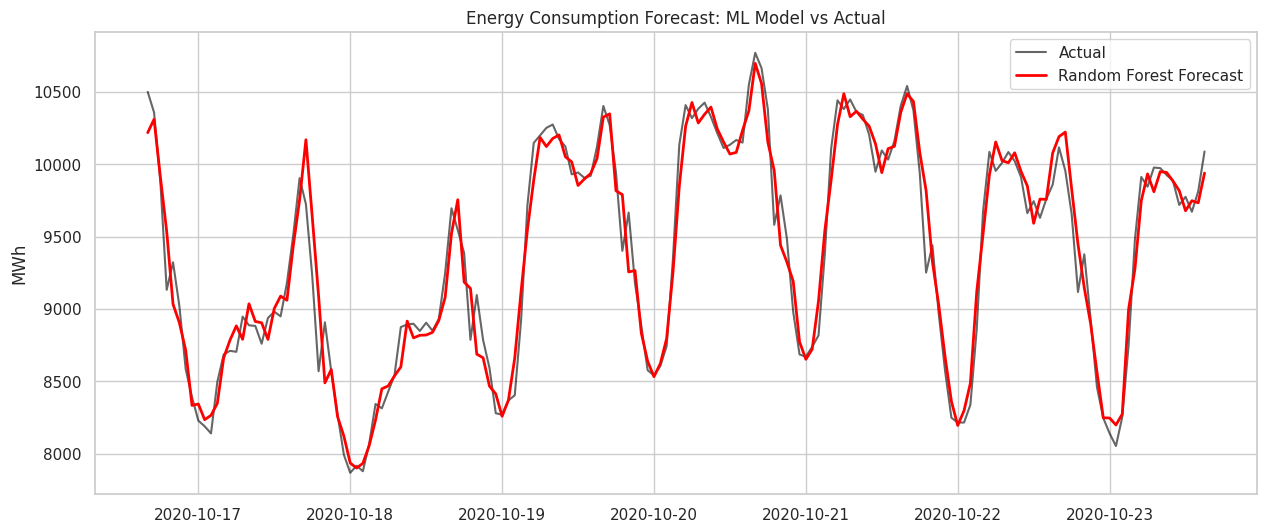

In [23]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 1. Load and prepare features (Assuming df is already loaded as per your code)
# We use the features we engineered earlier: hour, day_of_week, month, lags
features = ['hour', 'day_of_week', 'month', 'is_weekend', 'lag_1h', 'lag_24h']
target = 'Electricity consumption (MWh)'

# Drop rows with NaN values created by shift/lag operations
df_ml = df.dropna()

X = df_ml[features]
y = df_ml[target]

# 2. Chronological Split (Train on past, Test on future)
split_index = int(len(df_ml) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# 3. Baseline Model: Naive Persistence (Predicting t using t-1)
y_baseline = X_test['lag_1h']

# 4. ML Model: Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# 5. Evaluation
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
base_rmse = np.sqrt(mean_squared_error(y_test, y_baseline))

print(f"Baseline (Naive) RMSE: {base_rmse:.2f}")
print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"Accuracy Improvement: {((base_rmse - rf_rmse) / base_rmse) * 100:.2f}%")

# 6. Visualize Results (First 7 days of test set)
plt.figure(figsize=(15, 6))
plt.plot(y_test.index[:168], y_test.values[:168], label='Actual', color='black', alpha=0.6)
plt.plot(y_test.index[:168], y_pred[:168], label='Random Forest Forecast', color='red', linewidth=2)
plt.title('Energy Consumption Forecast: ML Model vs Actual')
plt.ylabel('MWh')
plt.legend()
plt.show()